## Imports

In [984]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score
from imblearn.over_sampling import SMOTENC,SMOTE
import warnings
import PySimpleGUI as sg
from joblib import dump, load
warnings.filterwarnings('ignore')

## Data Reading

In [985]:
df=pd.read_excel('Adult Census Income_Dataset.xlsx')                                                                                                                

In [986]:
df.to_csv('Adult Income New.csv')

In [987]:
df=pd.read_csv('Adult Income New.csv')

## Data Exploration

In [988]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [989]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32561 non-null  int64 
 1   age             32561 non-null  int64 
 2   workclass       32561 non-null  object
 3   fnlwgt          32561 non-null  int64 
 4   education       32561 non-null  object
 5   education.num   32561 non-null  int64 
 6   marital.status  32561 non-null  object
 7   occupation      32561 non-null  object
 8   relationship    32561 non-null  object
 9   race            32561 non-null  object
 10  sex             32561 non-null  object
 11  capital.gain    32561 non-null  int64 
 12  capital.loss    32561 non-null  int64 
 13  hours.per.week  32561 non-null  int64 
 14  native.country  32561 non-null  object
 15  income          32561 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


In [990]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,32561.0,16280.000000,9399.695394,0.0,8140.0,16280.0,24420.0,32560.0
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education.num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital.gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital.loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [991]:
print('Number of rows:', df.shape[0])

Number of rows: 32561


In [992]:
print('Number of columns:', df.shape[1])

Number of columns: 16


## EDA

<Axes: xlabel='age', ylabel='Density'>

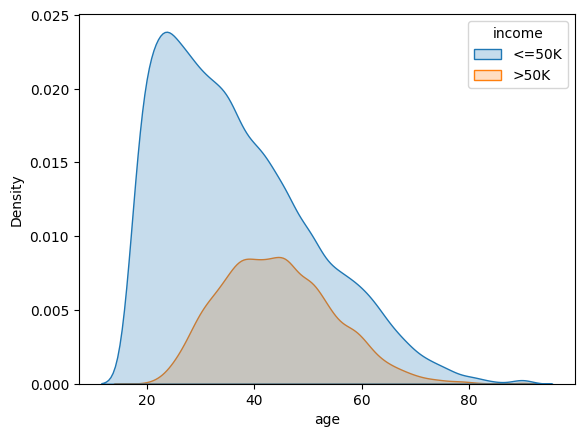

In [993]:
sns.kdeplot(x='age',data=df,hue='income',fill=True)

<Axes: xlabel='education.num', ylabel='count'>

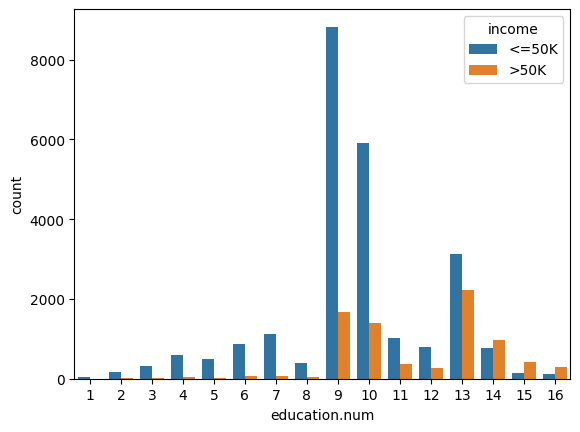

In [994]:
sns.countplot(data=df,x='education.num',hue='income')

<Axes: xlabel='capital.loss', ylabel='age'>

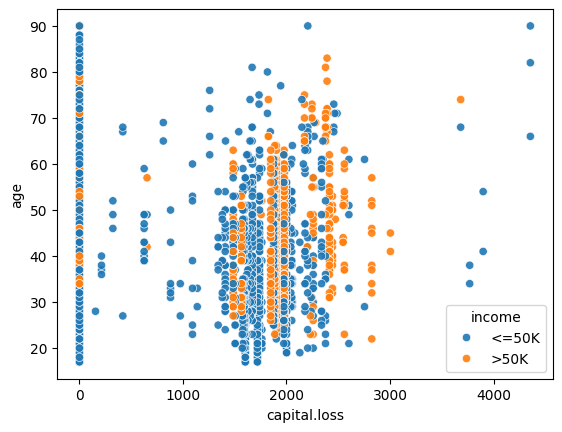

In [995]:
sns.scatterplot(x='capital.loss',y='age',data=df,hue='income',alpha=0.9)

## Data Pre-Proccessing

### Data Conversion

In [996]:
df['income']=df['income'].map({"<=50K":0,">50K":1})

<Axes: xlabel='income', ylabel='count'>

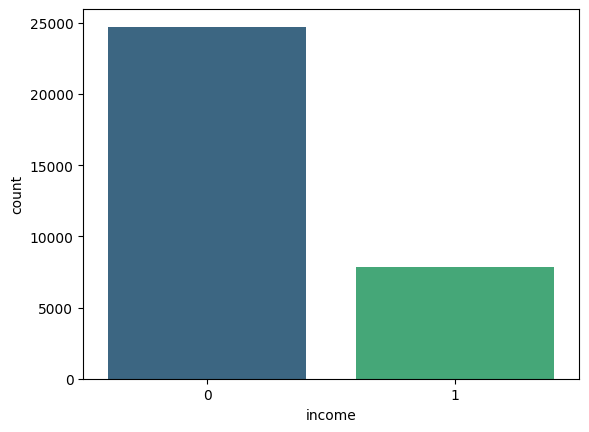

In [997]:
sns.countplot(x='income',data=df,palette='viridis')

In [998]:
columns=df.columns
df[columns]=df.replace('?',np.nan)

### Duplicates

In [999]:
df.duplicated().sum()

0

### Missing Data

In [1000]:
100*(df.isnull().sum()/len(df))

Unnamed: 0        0.000000
age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

In [1001]:
mode_nativecountry=df['native.country'].mode()[0]

In [1002]:
df['workclass']=df['workclass'].fillna('Unemployed')
df['occupation']=df['occupation'].fillna('None')
df['native.country']=df['native.country'].fillna(mode_nativecountry)

In [1003]:
df.isnull().sum()

Unnamed: 0        0
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [1004]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,0,90,Unemployed,77053,HS-grad,9,Widowed,None,Not-in-family,White,Female,0,4356,40,United-States,0
1,1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,2,66,Unemployed,186061,Some-college,10,Widowed,None,Unmarried,Black,Female,0,4356,40,United-States,0
3,3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [1005]:
df=df.drop("Unnamed: 0",axis=1)

In [1006]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [1007]:
df.corr(numeric_only=True)['income'].sort_values(ascending=False)

income            1.000000
education.num     0.335154
age               0.234037
hours.per.week    0.229689
capital.gain      0.223329
capital.loss      0.150526
fnlwgt           -0.009463
Name: income, dtype: float64

<Axes: >

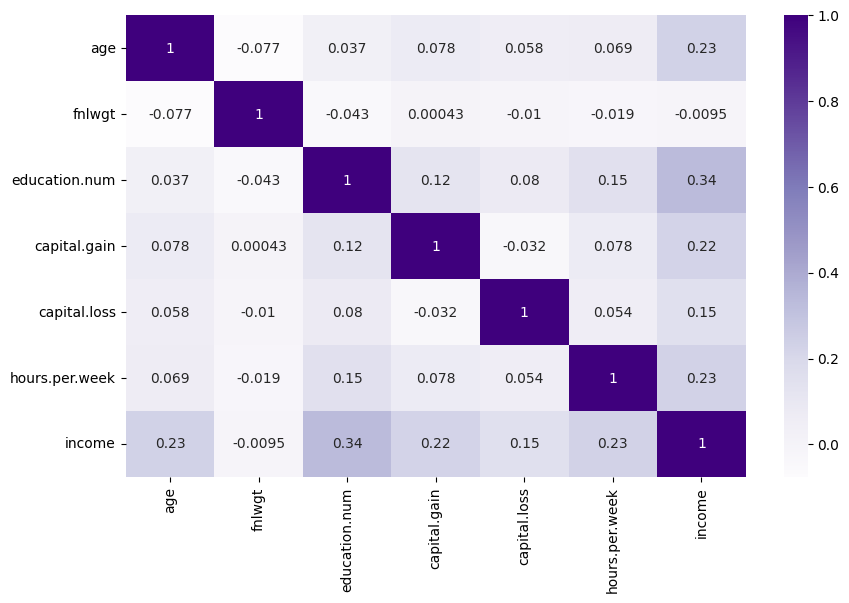

In [1008]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='Purples')

### Clipping Outliers

In [1009]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

data_without_outliers = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

max_age = data_without_outliers['age'].max()
minAge=data_without_outliers['age'].min()
print(lower_bound)
print(upper_bound)

-2.0
78.0


In [1010]:
a=df['age']
outliers = a[(a < lower_bound) | (a > upper_bound)]
len(outliers)

143

<Axes: ylabel='age'>

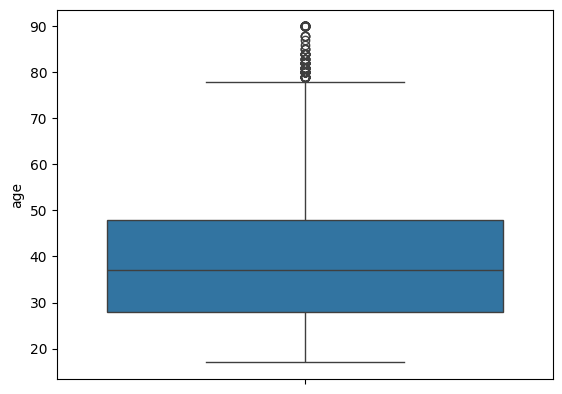

In [1011]:
sns.boxplot(data = df, y = 'age')

In [1012]:
df[df['age'] > upper_bound]['income'].value_counts()

income
0    118
1     25
Name: count, dtype: int64

In [1013]:
df[df['age']< lower_bound]['income'].value_counts()

Series([], Name: count, dtype: int64)

In [1014]:
df['age'] = df["age"].clip(lower=lower_bound,upper=upper_bound)

## Feature Engineering

#### Feature Expansion

In [1015]:
def ageGrouping(column):
    if column<= 30 & column>=17:
        return "Youth"
    elif column <= 50:
        return "Middle-aged"
    else:
        return "Senior"      

In [1016]:
df['ageGroup'] = df['age'].apply(ageGrouping)

In [1017]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ageGroup
0,78,Unemployed,77053,HS-grad,9,Widowed,None,Not-in-family,White,Female,0,4356,40,United-States,0,Senior
1,78,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,Senior
2,66,Unemployed,186061,Some-college,10,Widowed,None,Unmarried,Black,Female,0,4356,40,United-States,0,Senior
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,Senior
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,Middle-aged


In [1018]:
df.tail()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ageGroup
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0,Youth
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,Middle-aged
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,Middle-aged
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,Senior
32560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,Youth


In [1019]:
df['net']=df['capital.gain']-df['capital.loss']

In [1020]:
df["work_hours_per_age"] = df["hours.per.week"] / df["age"]  # Workload relative to age
df["hours_category"] = pd.cut(df["hours.per.week"], bins=[0, 30, 40, 60, 100], labels=["Part-time", "Full-time", "Overtime", "Extreme"])
df["capital_activity"] = np.where((df["capital.gain"] > 0) | (df["capital.loss"] > 0), 1, 0)  # 1 if either capital gain or loss is 1, 0 otherwise

In [1021]:
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ageGroup,net,work_hours_per_age,hours_category,capital_activity
0,78,Unemployed,77053,HS-grad,9,Widowed,None,Not-in-family,White,Female,0,4356,40,United-States,0,Senior,-4356,0.512821,Full-time,1
1,78,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,Senior,-4356,0.230769,Part-time,1
2,66,Unemployed,186061,Some-college,10,Widowed,None,Unmarried,Black,Female,0,4356,40,United-States,0,Senior,-4356,0.606061,Full-time,1
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,Senior,-3900,0.740741,Full-time,1
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,Middle-aged,-3900,0.975610,Full-time,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0,Youth,0,1.818182,Full-time,0
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,Middle-aged,0,1.407407,Full-time,0
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,Middle-aged,0,1.000000,Full-time,0
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,Senior,0,0.689655,Full-time,0


### Mapping

In [1022]:
df['marital.status'].value_counts()

marital.status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64

In [1023]:
marital_income_percent = df.groupby('marital.status')['income'].value_counts(normalize=True).unstack()
print(marital_income_percent*100)

income                         0          1
marital.status                             
Divorced               89.579113  10.420887
Married-AF-spouse      56.521739  43.478261
Married-civ-spouse     55.315171  44.684829
Married-spouse-absent  91.866029   8.133971
Never-married          95.403913   4.596087
Separated              93.560976   6.439024
Widowed                91.440081   8.559919


In [1024]:
# Define mapping for marital.status
marital_status_mapping = {
    'Married-civ-spouse': 'Married-spouse-present',
    'Married-AF-spouse': 'Married-spouse-present',
    'Married-spouse-absent':'Absent',
    'Widowed': 'Absent',
    'Divorced':'Divorced',
    'Separated':'No-partner',
    'Never-married':'No-partner',
}
# Apply the mapping to combine categories
df['marital.status'] = df['marital.status'].map(marital_status_mapping)

In [1025]:
# Recalculate income percentages for the new groups
new_marital_income_percent = df.groupby('marital.status')['income'].value_counts(normalize=True).unstack()
print(new_marital_income_percent*100)

income                          0          1
marital.status                              
Absent                  91.566265   8.433735
Divorced                89.579113  10.420887
Married-spouse-present  55.317021  44.682979
No-partner              95.242569   4.757431


In [1026]:
df['native.country'].value_counts()

native.country
United-States                 29753
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                           29
France       

In [1027]:
df['native.country'] = df['native.country'].apply(lambda x: 'Other' if x != 'United-States'else x)

In [1028]:
df['occupation'].value_counts()

occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
None                 1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64

In [1029]:
df['occupation'] = df['occupation'].apply(
    lambda x: x if df['occupation'].value_counts()[x] > 1000 else 'Other'
)

In [1030]:
df['education'].value_counts()

education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

In [1031]:

df['education'] = df['education'].apply(lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th'  or x == '5th-6th' or
                                         x == '9th' or x == '12th' or x == '1st-4th' or x == 'Preschool' else x)
df['education'] = df['education'].apply(lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x)
df['education'] = df['education'].apply(lambda x: 'Post-masters' if x == 'Doctorate' or x == 'Prof-school' else x)

education_map = {'School':1,
             'HS-grad':2,
             'Some-college':3,
             'Associate':4,
             'Bachelors':5,
             'Masters':6,
             'Post-masters':7}
df['education'] = df['education'].map(education_map)


In [1032]:
df['workclass'].value_counts()

workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
Unemployed           1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

In [1033]:
workclass_mapping = {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self-emp-not-inc',
    'Local-gov': 'Local-gov',
    'Unemployed': 'Unemployed', 
    'State-gov': 'State-gov',
    'Self-emp-inc': 'Self-emp-inc',  
    'Federal-gov': 'Federal-gov',
    'Without-pay': 'Not-paid',
    'Never-worked': 'Not-paid' 
}

df['workclass'] = df['workclass'].map(workclass_mapping)

In [1034]:
df['race'].value_counts()

race
White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64

In [1035]:
race_percent = df.groupby('race')['income'].value_counts(normalize=True).unstack()
print(race_percent*100)

income                      0          1
race                                    
Amer-Indian-Eskimo  88.424437  11.575563
Asian-Pac-Islander  73.435996  26.564004
Black               87.612036  12.387964
Other               90.774908   9.225092
White               74.414006  25.585994


In [1036]:
race_mapping = {
    'Other': 'Other',
    'Amer-Indian-Eskimo': 'Black',
    'Black': 'Black',
    'White': 'White',
    'Asian-Pac-Islander': 'White',
}

df['race'] = df['race'].map(race_mapping)

### Data Encoding

#### Ordinal Encoding

In [1037]:
ageGroupOrder=['Youth','Middle-aged','Senior']
hours_category_order=["Part-time", "Full-time", "Overtime", "Extreme"]

In [1038]:
df['ageGroup'] = df['ageGroup'].astype(str)
df['hours_category'] = df['hours_category'].astype(str)

# Initialize OrdinalEncoder with correct categories
ordinal_encoder = OrdinalEncoder(categories=[ ageGroupOrder, hours_category_order])

# Fit and transform the specified columns
df[['ageGroup', 'hours_category']] = ordinal_encoder.fit_transform(df[[ 'ageGroup', 'hours_category']]).astype(int)

# Save the encoder
dump(ordinal_encoder, 'ordinal_encoder.joblib')

print(df[[ 'ageGroup', 'hours_category']].head())

   ageGroup  hours_category
0         2               1
1         2               0
2         2               1
3         2               1
4         1               1


In [1039]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ageGroup,net,work_hours_per_age,hours_category,capital_activity
0,78,Unemployed,77053,2,9,Absent,None,Not-in-family,White,Female,0,4356,40,United-States,0,2,-4356,0.512821,1,1
1,78,Private,132870,2,9,Absent,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,2,-4356,0.230769,0,1
2,66,Unemployed,186061,3,10,Absent,None,Unmarried,Black,Female,0,4356,40,United-States,0,2,-4356,0.606061,1,1
3,54,Private,140359,1,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,2,-3900,0.740741,1,1
4,41,Private,264663,3,10,No-partner,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,1,-3900,0.975610,1,1


#### OneHot Encoding

In [1040]:
OneHotColumns=['workclass','marital.status','occupation','relationship','race','sex','native.country']

df_encoded = pd.get_dummies(df[OneHotColumns], drop_first=True).astype(int)
df_remaining = df.drop(columns=OneHotColumns)
df = pd.concat([df_remaining, df_encoded], axis=1)

feature_order = df.columns.tolist()
feature_order.remove('income')
dump(feature_order, 'feature_order.joblib')

['feature_order.joblib']

In [1041]:
len(feature_order)   

41

In [1042]:
file_path = r"my_dataframe.csv"

df.to_csv(file_path, index=False, encoding='utf-8')

In [1043]:
df.corr()['income'].sort_values(ascending=False)

income                                   1.000000
marital.status_Married-spouse-present    0.445289
education                                0.357136
education.num                            0.335154
capital_activity                         0.305720
hours_category                           0.256174
age                                      0.235865
hours.per.week                           0.229689
capital.gain                             0.223329
sex_Male                                 0.215980
occupation_Exec-managerial               0.214861
net                                      0.214428
occupation_Prof-specialty                0.185866
ageGroup                                 0.171874
capital.loss                             0.150526
workclass_Self-emp-inc                   0.139467
relationship_Wife                        0.123264
race_White                               0.100517
native.country_United-States             0.038942
workclass_Local-gov                      0.033091


In [1044]:
df[df["income"].isnull()]

,age,fnlwgt,education,education.num,capital.gain,capital.loss,hours.per.week,income,ageGroup,net,...,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Other,race_White,sex_Male,native.country_United-States


## Machine Learning

### Data Splitting

In [1045]:
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Data Scaling

In [1046]:
scaler=StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)           

### Checking outliers

-0.8173578189943393 0.4161995480827274
Outliers: [ 1.43968989  0.96194408  1.61286334 -0.97776914  0.66228123  1.07806479
  2.62995014  0.70366585]
8
0.02456926998556555


<Axes: >

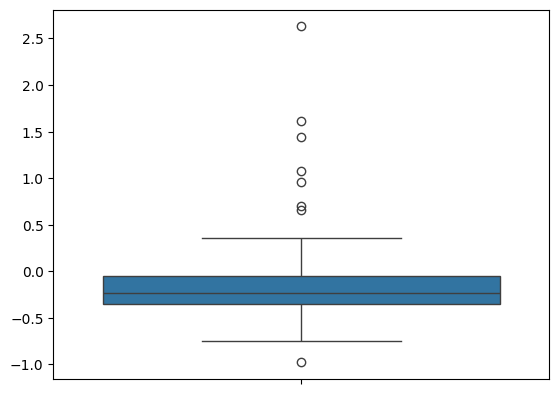

In [1047]:
a = np.array(X_train[0])
Q1 = np.percentile(a, 25)
Q3 = np.percentile(a, 75)
IQR = Q3 - Q1

# Define the outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound, upper_bound)
# Find the outliers
outliers = a[(a < lower_bound) | (a > upper_bound)]
print("Outliers:", outliers)
print(len(outliers))
print(len(outliers)/df.shape[0] *100 )

sns.boxplot(a)

###  Handling Imbalance

In [1048]:
len(X_train)

22792

In [1049]:
y_train.value_counts()

income
0    17291
1     5501
Name: count, dtype: int64

In [1050]:
smote_nc = SMOTE(random_state=42, k_neighbors=3, sampling_strategy=0.5)
X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)

resampled_data = pd.DataFrame(X_train_res, columns=X.columns)
resampled_data['income'] = y_train_res
resampled_data.to_csv("adult_income_resampled.csv",index=False)

In [1051]:
len(X_train_res)

25936

In [1052]:
y_train_res.value_counts()

income
0    17291
1     8645
Name: count, dtype: int64

## Models

### Logistic Regression

In [ ]:
param_grid = {
    'C':np.logspace(-20,0,20), #Regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'], # Solvers
    'penalty':['l2','l1']
}
log_model = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
log_model.fit(X_train_res,y_train_res)


#best param:1,saga,l2

#log_model=LogisticRegression(C=1.0,solver='saga',penalty='l2')
#log_model.fit(X_train_res,y_train_res)

y_pred_test=log_model.predict(X_test)
y_pred_train=log_model.predict(X_train_res)

print("Train Accuracy (Logisitc):", accuracy_score(y_train_res, y_pred_train))
print("Test Accuracy (Logistic):", accuracy_score(y_test, y_pred_test))

# Confusion Matrix, Classification Report, and ROC-AUC Score
confusion_log = confusion_matrix(y_test, y_pred_test )
report_log = classification_report(y_test, y_pred_test)
roc_score_log = roc_auc_score(y_test, y_pred_test)

print("\nConfusion Matrix (Logistic):\n", confusion_log)
print("\nClassification Report (Logistic):\n\n", report_log)
print("\nROC-AUC Score (Logistic):", roc_score_log)

dump(log_model,"logistic_model.joblib")

Train Accuracy (Logisitc): 0.8367134484885873
Test Accuracy (Logistic): 0.8485003582761798

Confusion Matrix (Logistic):
 [[6654  775]
 [ 705 1635]]

Classification Report (Logistic):

               precision    recall  f1-score   support

           0       0.90      0.90      0.90      7429
           1       0.68      0.70      0.69      2340

    accuracy                           0.85      9769
   macro avg       0.79      0.80      0.79      9769
weighted avg       0.85      0.85      0.85      9769


ROC-AUC Score (Logistic): 0.7971985220773752


['logistic_model.joblib']

In [1054]:
log_model.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}

### KNN

In [1055]:
test_accuracy = []
train_accuracy = []
Gap= []
for d in range(1, 31):
    model = KNeighborsClassifier(n_neighbors=d,metric='manhattan')
    model.fit(X_train_res, y_train_res)

    y_pred_train = model.predict(X_train_res)
    y_pred_test = model.predict(X_test)
    
   
    train_accuracy.append(accuracy_score(y_train_res, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    Gap.append(accuracy_score(y_train_res, y_pred_train) - accuracy_score(y_test, y_pred_test) )
    
best_min = min(Gap)
best_k = Gap.index(best_min)+1
print(best_k)

30


Bets k:28

In [1056]:
knn_model = KNeighborsClassifier(n_neighbors=30, metric='manhattan')


knn_model.fit(X_train_res,y_train_res)

y_pred_test=knn_model.predict(X_test)
y_pred_train=knn_model.predict(X_train_res)


print("Train Accuracy (KNN):", accuracy_score(y_train_res, y_pred_train))
print("Test Accuracy (KNN):", accuracy_score(y_test, y_pred_test))


confusion_KNN = confusion_matrix(y_test, y_pred_test )
report_KNN = classification_report(y_test, y_pred_test)
roc_score_KNN = roc_auc_score(y_test, y_pred_test)

print("\nConfusion Matrix (KNN):\n", confusion_KNN)

print("\nClassification Report (KNN):\n\n", report_KNN)
print("\nROC-AUC Score (KNN):", roc_score_KNN)

dump(knn_model,"knn_model.joblib")

Train Accuracy (KNN): 0.83775447254781
Test Accuracy (KNN): 0.8382638959975433

Confusion Matrix (KNN):
 [[6535  894]
 [ 686 1654]]

Classification Report (KNN):

               precision    recall  f1-score   support

           0       0.90      0.88      0.89      7429
           1       0.65      0.71      0.68      2340

    accuracy                           0.84      9769
   macro avg       0.78      0.79      0.78      9769
weighted avg       0.84      0.84      0.84      9769


ROC-AUC Score (KNN): 0.7932491978191265


['knn_model.joblib']

### Decision Tree

In [1057]:
param_grid = {
    'max_depth': [None, 10, 20, 30,40],
    'min_samples_split': [2,5,8,10,13,15,19],
    'min_samples_leaf': [1,2,3,4,5,6,7,8],
    'criterion': ['gini', 'entropy','log_loss']  # Criterion to measure the quality of a split
}

#DT_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1,verbose=1)
#bestparam: criterion='entropy',max_depth=10,min_samples_split=12,min_samples_leaf=10)

DT_model=DecisionTreeClassifier(criterion='entropy',max_depth=10,min_samples_split=12,min_samples_leaf=10)
DT_model.fit(X_train_res,y_train_res)

y_pred_test=DT_model.predict(X_test)
y_pred_train=DT_model.predict(X_train_res)

print("Train Accuracy (DT):", accuracy_score(y_train_res, y_pred_train))
print("Test Accuracy (DT):", accuracy_score(y_test, y_pred_test))

confusion_DT = confusion_matrix(y_test, y_pred_test )
report_DT = classification_report(y_test, y_pred_test)
roc_score_DT = roc_auc_score(y_test, y_pred_test)

print("\nConfusion Matrix (DT):\n", confusion_DT)
print("\nClassification Report (DT):\n\n", report_DT)
print("\nROC-AUC Score (DT):", roc_score_DT)
dump(DT_model,'DT_model.joblib')

Train Accuracy (DT): 0.849437075879087
Test Accuracy (DT): 0.8473743474255298

Confusion Matrix (DT):
 [[6699  730]
 [ 761 1579]]

Classification Report (DT):

               precision    recall  f1-score   support

           0       0.90      0.90      0.90      7429
           1       0.68      0.67      0.68      2340

    accuracy                           0.85      9769
   macro avg       0.79      0.79      0.79      9769
weighted avg       0.85      0.85      0.85      9769


ROC-AUC Score (DT): 0.7882613815343659


['DT_model.joblib']

In [980]:
DT_model.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 19}

### Support Vector Machine

In [982]:
'''param_grid = {
    'kernel': ['linear', 'rbf', 'poly','sigmoid'],
    'C': [0.1,1,10,100,1000],
    'gamma': ['scale', 'auto']  
}
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose = 1)'''

svm=SVC(kernel='rbf',C=0.1,gamma='scale')

svm.fit(X_train_res, y_train_res)
y_pred_test=svm.predict(X_test)
y_pred_train=svm.predict(X_train_res)

print("Train Accuracy (SVM):", accuracy_score(y_train_res, y_pred_train))
print("Test Accuracy (SVM):", accuracy_score(y_test, y_pred_test))

confusion_SVM = confusion_matrix(y_test, y_pred_test )
report_SVM = classification_report(y_test, y_pred_test)
roc_score_SVM = roc_auc_score(y_test, y_pred_test)

print("\nConfusion Matrix (SVM):\n", confusion_SVM)
print("\nClassification Report (SVM):\n\n", report_SVM)
print("\nROC-AUC Score (SVM):", roc_score_SVM)

dump(svm,'SVM.joblib')

KeyboardInterrupt: 

In [ ]:
svm.best_params_

### Ada Boost

In [499]:
"""param_grid_adaboost = {
    'n_estimators': list(range(100,200)),  
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}
adaboost_model = GridSearchCV(estimator=AdaBoostClassifier(),param_grid=param_grid_adaboost,cv=5,scoring='accuracy',n_jobs=-1)"""

adaboost_model=AdaBoostClassifier(learning_rate=1,n_estimators=150)
adaboost_model.fit(X_train_res, y_train_res)

y_pred_test_adaboost = adaboost_model.predict(X_test)
y_pred_train_adaboost = adaboost_model.predict(X_train_res)

print("Train Accuracy (AdaBoost):", accuracy_score(y_train_res, y_pred_train_adaboost))
print("Test Accuracy (AdaBoost):", accuracy_score(y_test, y_pred_test_adaboost))

confusion_ada = confusion_matrix(y_test, y_pred_test_adaboost)
report_ada = classification_report(y_test, y_pred_test_adaboost)
roc_score_ada = roc_auc_score(y_test, y_pred_test_adaboost)

print("\nConfusion Matrix (AdaBoost):\n", confusion_ada)
print("\nClassification Report (AdaBoost):\n", report_ada)
print("\nROC-AUC Score (AdaBoost):", roc_score_ada)
dump(adaboost_model,'adaboost_model.joblib')

Train Accuracy (AdaBoost): 0.8580737199259716
Test Accuracy (AdaBoost): 0.8629337700890573

Confusion Matrix (AdaBoost):
 [[6826  603]
 [ 736 1604]]

Classification Report (AdaBoost):
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      7429
           1       0.73      0.69      0.71      2340

    accuracy                           0.86      9769
   macro avg       0.81      0.80      0.81      9769
weighted avg       0.86      0.86      0.86      9769


ROC-AUC Score (AdaBoost): 0.8021508456694887


['adaboost_model.joblib']

In [669]:
adaboost_model.best_params_

AttributeError: 'AdaBoostClassifier' object has no attribute 'best_params_'

## GUI

In [834]:
df_input_encoded=0

In [907]:
def model_load(model_name):
    model = load(model_name+'.joblib')
    y_pred_test = model.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_pred_test)
    report = classification_report(y_test, y_pred_test)
    ROCscore = roc_auc_score(y_test, y_pred_test)
    
    return confusion, report, ROCscore
def ageGrouping(column):
    if 17 <= column <= 30:
        return "Youth"
    elif column <= 50:
        return "Middle-aged"
    else:
        return "Senior" 

def prepare_input_data(input_data):

    # Convert input to dataframe
    df_input = pd.DataFrame([input_data])


    # Mapping dictionaries
    workclass_mapping = {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self-emp-not-inc',
    'Local-gov': 'Local-gov',
    'Unemployed': 'Unemployed', 
    'State-gov': 'State-gov',
    'Self-emp-inc': 'Self-emp-inc',  
    'Federal-gov': 'Federal-gov',
    'Without-pay': 'Not-paid',
    'Never-worked': 'Not-paid' 
    }
    df_input['education'] = df_input['education'].apply(lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th'  or x == '5th-6th' or
                                         x == '9th' or x == '12th' or x == '1st-4th' or x == 'Preschool' else x)
    df_input['education'] = df_input['education'].apply(lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x)
    df_input['education'] = df_input['education'].apply(lambda x: 'Post-masters' if x == 'Doctorate' or x == 'Prof-school' else x)

    education_map = {'School':1,
        'HS-grad':2,
        'Some-college':3,
        'Associate':4,
        'Bachelors':5,
        'Masters':6,
        'Post-masters':7}
    
    occupation_mapping = {'Prof-specialty' : 'Prof-specialty',  
        'Craft-repair' : 'Craft-repair',    
        'Exec-managerial' : 'Exec-managerial',
        'Adm-clerical' : 'Adm-clerical',   
        'Sales' : 'Sales',          
        'Other-service' : 'Other-service'  , 
        'Machine-op-inspct': 'Machine-op-inspct',   
        'None' : 'None' ,               
        'Transport-moving' : 'Transport-moving' ,   
        'Handlers-cleaners' : 'Handlers-cleaners' ,
        'Farming-fishing' : 'Other',    
        'Tech-support' : 'Other',
        'Protective-serv' : 'Other',
        'Priv-house-serv' : 'Other',
        ' Armed-Forces': 'Other'}
    
    
    
    
    marital_status_mapping = {
        'Married-civ-spouse': 'Married-spouse-present',
        'Married-AF-spouse': 'Married-spouse-present',
        'Married-spouse-absent': 'Absent',
        'Widowed': 'Absent',
        'Divorced': 'Divorced',
        'Separated': 'No-partner',
        'Never-married': 'No-partner',
    }
    
    race_mapping = {
        'Other': 'Other',
        'Amer-Indian-Eskimo': 'Black',
        'Black': 'Black',
        'White': 'White',
        'Asian-Pac-Islander': 'White',
    }

    # Apply mappings
    df_input['native.country'] = df_input['native.country'].apply(lambda x: 'Other' if x != 'United-States'else x)
    df_input['occupation'] = df_input['occupation'].map(occupation_mapping)  
    df_input['marital.status'] = df_input['marital.status'].map(marital_status_mapping)
    df_input['race'] = df_input['race'].map(race_mapping)
    df_input['education'] = df_input['education'].map(education_map)
    df_input['workclass'] = df_input['workclass'].map(workclass_mapping)

    
    # Load saved encoders
    ordinal_encoder = load('ordinal_encoder.joblib')
    feature_order = load('feature_order.joblib')

    df_input['ageGroup'] = df_input['age'].apply(ageGrouping)
    df_input['net'] = df_input['capital.gain'] - df_input['capital.loss']
    df_input["work_hours_per_age"] = df_input["hours.per.week"] / df_input["age"]
    df_input["hours_category"] = pd.cut(df_input["hours.per.week"], bins=[0, 30, 40, 60, 100], labels=["Part-time", "Full-time", "Overtime", "Extreme"])
    #df_input["family_structure"] = df_input["marital.status"] + "-" + df_input["relationship"]
    df_input["capital_activity"] = np.where((df_input["capital.gain"] > 0) | (df_input["capital.loss"] > 0), 1, 0)

    # Apply ordinal encoding
    df_input[[ 'ageGroup','hours_category']] = ordinal_encoder.transform(df_input[[ 'ageGroup','hours_category']]).astype(int)
    
    # Apply one-hot encoding using pd.get_dummies
    OneHotColumns = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
    df_input_encoded = pd.get_dummies(df_input, columns=OneHotColumns, drop_first=True).astype(int)

    feature_order = load('feature_order.joblib')
    # Ensure columns are in the same order as training data
    df_input_encoded = df_input_encoded.reindex(columns=feature_order, fill_value=0)
    
    return df_input_encoded,feature_order

In [908]:
FILE_PATH = r"my_dataframe.csv"
# 1. Dataset Loading
def load_dataset(file_path):
    global df, X_train, y_train, feature_columns
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully!")
        return True
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return False

# 2. Model Selection
def load_model(model_name):
    if model_name == "Logistic Regression":
        model = load('logistic_model.joblib')
    elif model_name == "Decision Tree":
        model = load('DT_model.joblib')
    elif model_name == "KNN":
        model = load('knn_model.joblib')
    elif model_name == "SVM":
        model = load('SVM.joblib')
    elif model_name == "Ada Boost":
        model = load('adaboost_model.joblib')
    return model

# 3. Prediction with Model
def predict_with_loaded_model(model_name, user_input_data):
    try:
        # Load the trained model
        model = load_model(model_name)  
        # Align user input data with training data features
        user_input_data=user_input_data.to_numpy()
        user_input_data=scaler.transform(user_input_data)
        # Make prediction
        prediction = model.predict(user_input_data)

        return prediction
    except Exception as e:

        print(f"Error during prediction: {e}")
        return None

# Dataset Loading Window
def dataset_loader_window():
    layout = [
        [sg.Text("Load Your Dataset", font=("Helvetica", 14))],
        [sg.Input(default_text=r"my_dataframe.csv", key="-FILE-", size=(70, 1))],
        [sg.FileBrowse(file_types=(("CSV Files", "*.csv"),))],
        [sg.Button("Load Dataset"), sg.Button("Exit")]
    ]
    return sg.Window("Load Dataset", layout, finalize=True, resizable=True)

# Model Selection Window
def model_selection_window():
    layout = [
        [sg.Text("Select a Model", font=("Helvetica", 14))],
        [sg.Combo(["Logistic Regression", "KNN", "Decision Tree", "SVM","Ada Boost"], key="-MODEL-", size=(20, 1))],
        [sg.Button("Train Model"), sg.Button("Predict"), sg.Button("Back")],
        [sg.Text("Results:", font=("Helvetica", 12))],
        [sg.Multiline(size=(70, 20), key="-RESULTS-", disabled=True)]  # Placeholder for displaying results
    ]
    return sg.Window("Model Selection", layout, finalize=True)

# Prediction Input Window
def prediction_input_window():
    layout = [
        [sg.Text("Enter feature values for prediction:")],
        [sg.Text("Age:"), sg.InputText(key="age")],
        [sg.Text("Workclass:"), sg.InputText(key="workclass")],
        [sg.Text("Fnlwgt:"), sg.InputText(key="fnlwgt")],
        [sg.Text("Education:"), sg.InputText(key="education")],
        [sg.Text("Education Number:"), sg.InputText(key="education.num")],
        [sg.Text("Marital Status:"), sg.InputText(key="marital.status")],
        [sg.Text("Occupation:"), sg.InputText(key="occupation")],
        [sg.Text("Relationship:"), sg.InputText(key="relationship")],
        [sg.Text("Race:"), sg.InputText(key="race")],
        [sg.Text("Sex:"), sg.InputText(key="sex")],
        [sg.Text("Capital Gain:"), sg.InputText(key="capital.gain")],
        [sg.Text("Capital Loss:"), sg.InputText(key="capital.loss")],
        [sg.Text("Hours per Week:"), sg.InputText(key="hours.per.week")],
        [sg.Text("Native Country:"), sg.InputText(key="native.country")],
        [sg.Button("Predict"), sg.Button("Back")]
    ]
    return sg.Window("Prediction Input", layout, finalize=True)

# Main Event Loop
def main():
    window1 = dataset_loader_window()
    window2 = None
    window3 = None

    while True:
        window, event, values = sg.read_all_windows()

        if event == sg.WINDOW_CLOSED or event == "Exit":
            if window:
                window.close()
            if window == window1:
                window1 = None
                break
            elif window == window2:
                window2 = None
            elif window == window3:
                window3 = None

        # Dataset Loader logic
        if window == window1:
            if event == "Load Dataset":
                file_path = r"my_dataframe.csv"
                if load_dataset(file_path):
                    sg.popup("Dataset loaded successfully!")
                    window1.close()
                    window1 = None
                    window2 = model_selection_window()  # Show model selection window
                else:
                    sg.popup_error("Failed to load dataset!")

        # Model Selection logic
        if window == window2:
            if event == "Train Model":
                selected_model = values["-MODEL-"]
                if not selected_model:
                    sg.popup_error("Please select a model!")
                else:
                    if selected_model == "Logistic Regression":
                        confusion, class_report, accuracy = model_load('logistic_model')
                        results_text = (
                            f"Confusion Matrix:\n{confusion}\n\n"
                            f"Classification Report:\n{class_report}\n\n"
                            f"ROC Score: {accuracy}\n"
                        )
                    elif selected_model == "KNN":
                        confusionknn, class_reportknn, ROCscoreknn = model_load('knn_model')
                        results_text = (
                            f"Confusion Matrix:\n{confusionknn}\n\n"
                            f"Classification Report:\n{class_reportknn}\n\n"
                            f"ROC Score: {ROCscoreknn}\n"
                        )
                    elif selected_model == "Decision Tree":
                        confusiontree, class_reporttree, ROCscoretree = model_load('DT_model')
                        results_text = (
                            f"Confusion Matrix:\n{confusiontree}\n\n"
                            f"Classification Report:\n{class_reporttree}\n\n"
                            f"ROC Score: {ROCscoretree}\n"
                        )
                    elif selected_model == "SVM":
                        confusionSVM, class_reportSVM, ROCscoreSVM = model_load('SVM')
                        results_text = (
                            f"Confusion Matrix:\n{confusionSVM}\n\n"
                            f"Classification Report:\n{class_reportSVM}\n\n"
                            f"ROC Score: {ROCscoreSVM}\n"
                        )
                    elif selected_model == "Ada Boost":
                        confusionada, class_reportada, ROCscoreada = model_load('adaboost_model')
                        results_text = (
                            f"Confusion Matrix:\n{confusionada}\n\n"
                            f"Classification Report:\n{class_reportada}\n\n"
                            f"ROC Score: {ROCscoreada}\n"
                        )

                    window2["-RESULTS-"].update(results_text)  # Display the results

            elif event == "Back":
                window2.close()
                window2 = None
                window1 = dataset_loader_window()

            elif event == "Predict":
                selected_model = values.get("-MODEL-")
                if not selected_model:
                    sg.popup_error("Please select a model first!")
                else:
                    window2.hide()
                    window3 = prediction_input_window()

        # Prediction Input logic
        if window == window3:
            if event == "Back":
                window3.close()
                window3 = None
                window2.un_hide()

            elif event == "Predict":
                try:
                    # Collect user input data from the form
                    user_input_data = {
                        'age': float(values["age"]),
                        'workclass': values["workclass"],
                        'fnlwgt': float(values["fnlwgt"]),
                        'education': values["education"],
                        'education.num': int(values["education.num"]),
                        'marital.status': values["marital.status"],
                        'occupation': values["occupation"],
                        'relationship': values["relationship"],
                        'race': values["race"],
                        'sex': values["sex"],
                        'capital.gain': float(values["capital.gain"]),
                        'capital.loss': float(values["capital.loss"]),
                        'hours.per.week': float(values["hours.per.week"]),
                        'native.country': values["native.country"]
                    }

                    input_df,feature_order = prepare_input_data(user_input_data)
                    print(input_df.columns)   

                    prediction = predict_with_loaded_model(selected_model, input_df)
                    if prediction is not None:
                        if prediction[0]==1:
                            sg.popup(f"Predicted Income: >50K")
                        else:
                            sg.popup(f"Predicted Income: <=50K")
                    else:
                        sg.popup_error("Prediction failed. Please check your inputs and try again.")

                except Exception as e:
                    sg.popup_error(f"Error during prediction: {e}")

if __name__ == "__main__":
  main()

Dataset loaded successfully!


KeyboardInterrupt: 